# Import Libraries

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, pearsonr
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
# Load the dataset
data = pd.read_csv("/content/StudentsPerformance.csv")

# Data Preprocessing

In [15]:
# Clean the Data
# Handle missing values
if data.isnull().sum().sum() > 0:
    data = data.dropna()

# Standardize numerical features if necessary
scaler = StandardScaler()
num_cols = ["math score", "reading score", "writing score"]
data[num_cols] = scaler.fit_transform(data[num_cols])

# Convert categorical variables to dummy variables
categorical_cols = ["gender", "race/ethnicity", "parental level of education", "lunch", "test preparation course"]
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Exploratory Data Analysis (EDA)

In [16]:
# Summary statistics
print("Summary Statistics:\n", data.describe())

Summary Statistics:
          math score  reading score  writing score
count  1.000000e+03   1.000000e+03   1.000000e+03
mean   8.704149e-17   2.167155e-16  -1.350031e-16
std    1.000500e+00   1.000500e+00   1.000500e+00
min   -4.360728e+00  -3.574960e+00  -3.822345e+00
25%   -5.997164e-01  -6.968462e-01  -6.784278e-01
50%   -5.872457e-03   5.694554e-02   6.228578e-02
75%    7.199368e-01   6.736842e-01   7.206978e-01
max    2.237538e+00   2.112741e+00   2.103363e+00


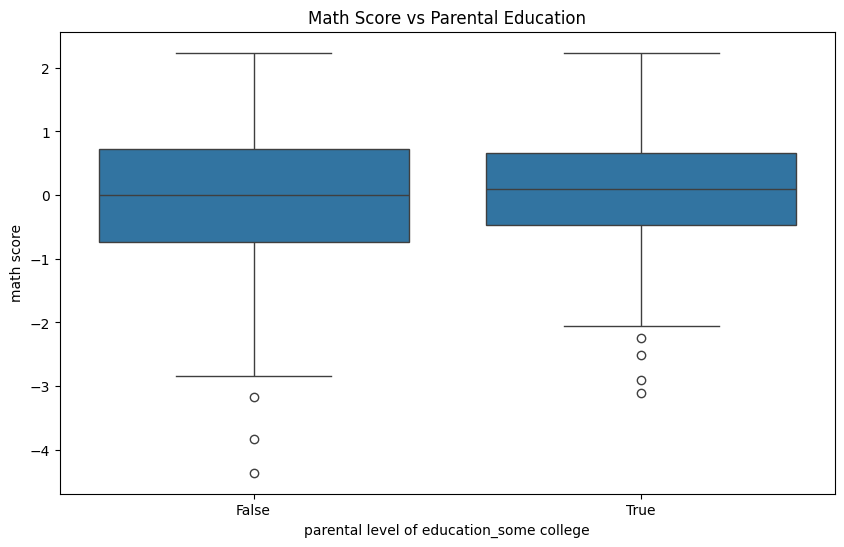

In [17]:
# Visualize relationships
plt.figure(figsize=(10, 6))
sns.boxplot(x="parental level of education_some college", y="math score", data=data)
plt.title("Math Score vs Parental Education")
plt.show()

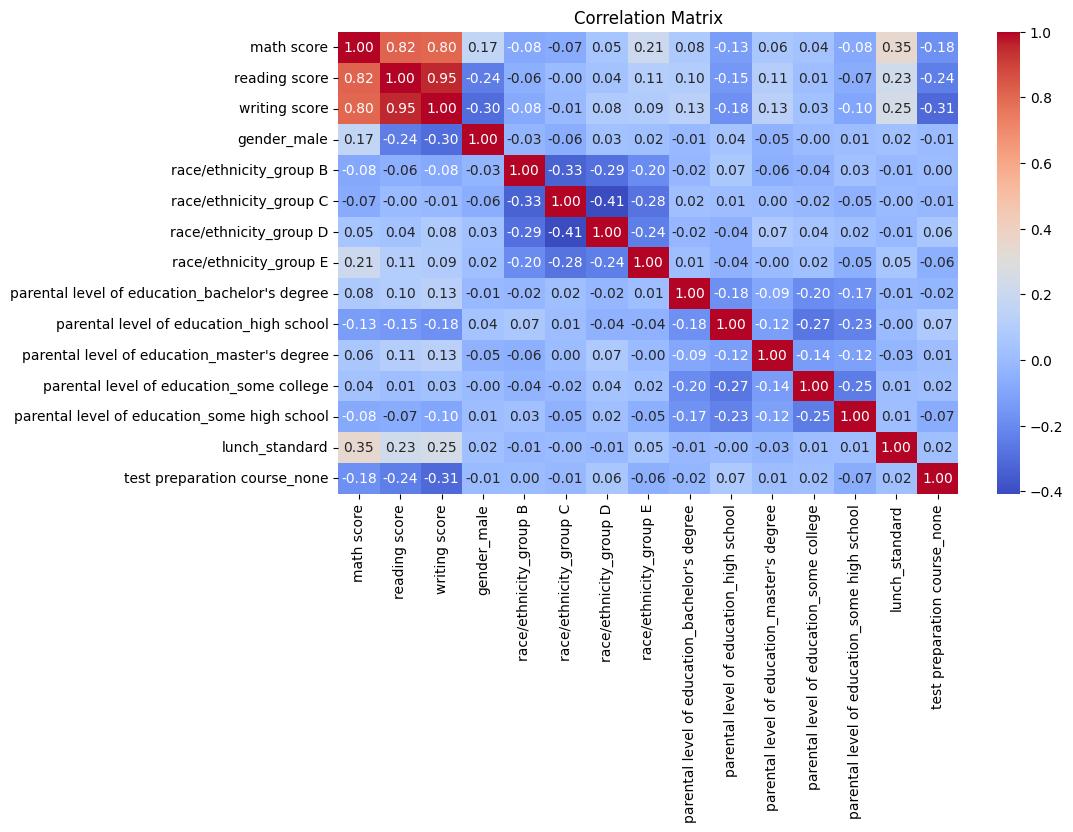

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

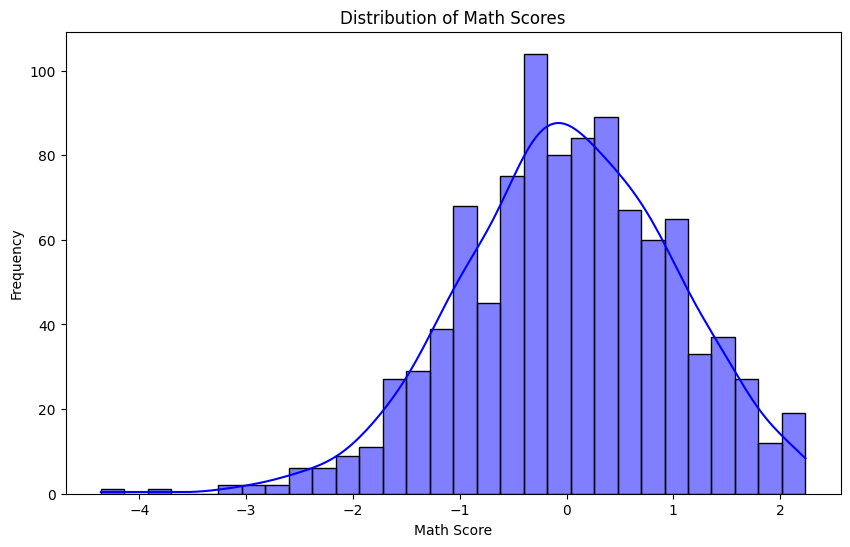

In [19]:
# Distribution of scores
plt.figure(figsize=(10, 6))
sns.histplot(data["math score"], kde=True, bins=30, color="blue")
plt.title("Distribution of Math Scores")
plt.xlabel("Math Score")
plt.ylabel("Frequency")
plt.show()

<Figure size 1000x600 with 0 Axes>

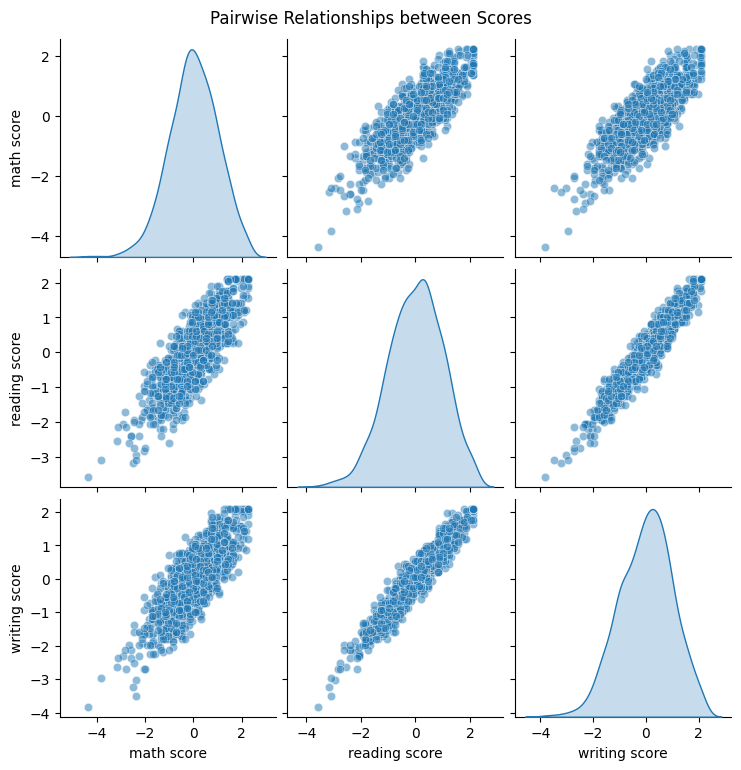

In [20]:
plt.figure(figsize=(10, 6))
sns.pairplot(data[num_cols], diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle("Pairwise Relationships between Scores", y=1.02)
plt.show()

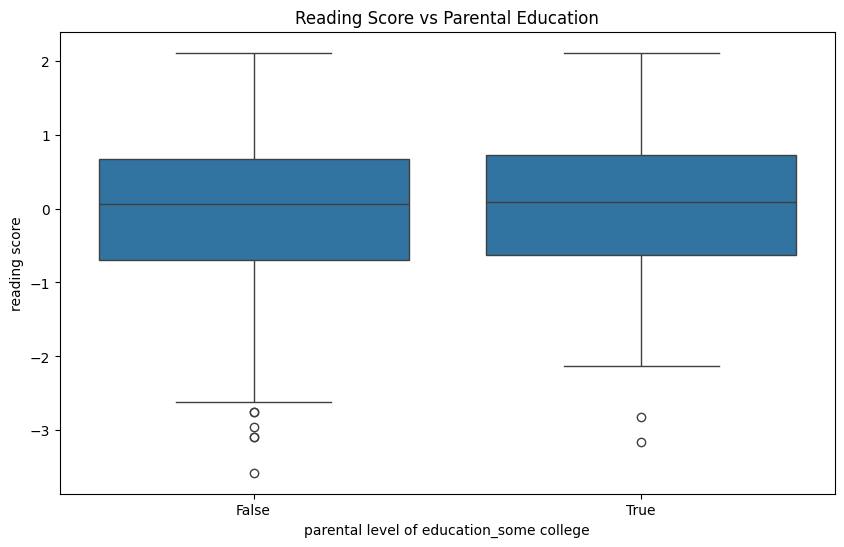

In [21]:
# Parental education vs all scores
plt.figure(figsize=(10, 6))
sns.boxplot(x="parental level of education_some college", y="reading score", data=data)
plt.title("Reading Score vs Parental Education")
plt.show()

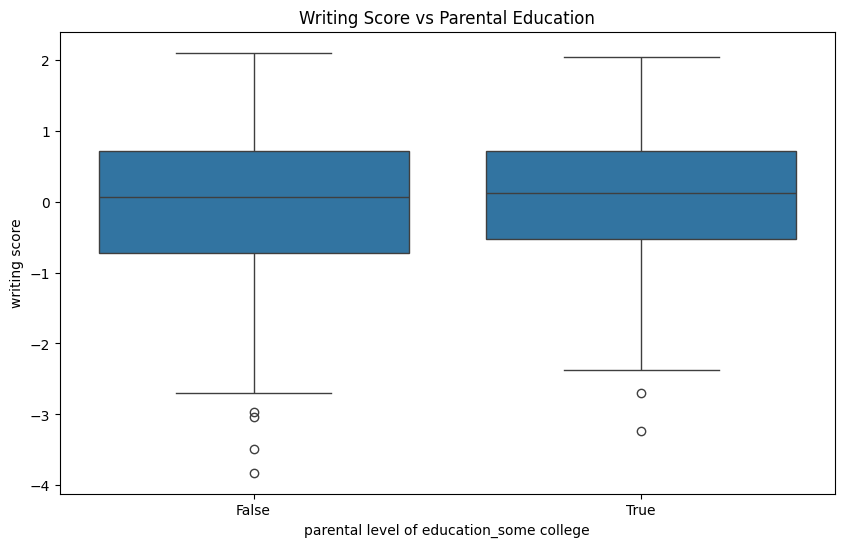

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="parental level of education_some college", y="writing score", data=data)
plt.title("Writing Score vs Parental Education")
plt.show()

# Statistical Hypothesis Testing

In [23]:
# ANOVA for parental education vs math score
groups = [data[data[col] == 1]["math score"] for col in data.columns if "parental level of education" in col]
F_stat, p_value = f_oneway(*groups)
print(f"ANOVA Results: F-statistic = {F_stat:.2f}, p-value = {p_value:.3e}")

# Correlation between scores
for score in ["reading score", "writing score"]:
    r, p = pearsonr(data["math score"], data[score])
    print(f"Correlation between math score and {score}: r = {r:.2f}, p-value = {p:.3e}")

# Additional hypothesis test: Impact of lunch on math score
# Get scores for 'standard' and 'free/reduced' lunch
standard_lunch_scores = data[data["lunch_standard"] == 1]["math score"]
free_reduced_lunch_scores = data[data["lunch_standard"] == 0]["math score"]

# Perform ANOVA
F_stat_lunch, p_value_lunch = f_oneway(standard_lunch_scores, free_reduced_lunch_scores)
print(f"ANOVA Results for Lunch: F-statistic = {F_stat_lunch:.2f}, p-value = {p_value_lunch:.3e}")

ANOVA Results: F-statistic = 7.17, p-value = 1.141e-05
Correlation between math score and reading score: r = 0.82, p-value = 1.788e-241
Correlation between math score and writing score: r = 0.80, p-value = 3.376e-226
ANOVA Results for Lunch: F-statistic = 140.12, p-value = 2.413e-30


# Confidence Interval Analysis

In [24]:
# Confidence intervals for mean scores by parental education
education_groups = data.columns[data.columns.str.contains("parental level of education")]
for col in education_groups:
    mean = data[data[col] == 1]["math score"].mean()
    std_err = data[data[col] == 1]["math score"].sem()
    conf_int = (mean - 1.96 * std_err, mean + 1.96 * std_err)
    print(f"Confidence Interval for {col}: {conf_int}")

Confidence Interval for parental level of education_bachelor's degree: (0.03988542965866729, 0.39570973196575765)
Confidence Interval for parental level of education_high school: (-0.3950247302248647, -0.12640257588047404)
Confidence Interval for parental level of education_master's degree: (-0.013860703816692632, 0.49642657334777135)
Confidence Interval for parental level of education_some college: (-0.05455167320504452, 0.191705685034875)
Confidence Interval for parental level of education_some high school: (-0.32497782473887665, -0.017049012691468024)


# Regression Analysis

In [32]:

X = data.drop(columns=["math score"])
y = data["math score"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Linear Regression
reg = LinearRegression()
reg.fit(X_train, y_train)

# Evaluate the Model
y_pred = reg.predict(X_test)
print("Regression Results:")
print(f"R^2 Score: {r2_score(y_test, y_pred):.2f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")

# Coefficients with confidence intervals
coefficients = pd.DataFrame({"Feature": X.columns, "Coefficient": reg.coef_})
coefficients["Lower Bound"] = coefficients["Coefficient"] - 1.96 * np.std(y_pred)
coefficients["Upper Bound"] = coefficients["Coefficient"] + 1.96 * np.std(y_pred)
print(coefficients)

Regression Results:
R^2 Score: 0.88
Mean Squared Error: 0.13
                                          Feature  Coefficient  Lower Bound  \
0                                   reading score     0.230949    -1.703900   
1                                   writing score     0.724655    -1.210194   
2                                     gender_male     0.856544    -1.078304   
3                          race/ethnicity_group B    -0.011682    -1.946531   
4                          race/ethnicity_group C    -0.052324    -1.987173   
5                          race/ethnicity_group D    -0.062543    -1.997392   
6                          race/ethnicity_group E     0.294882    -1.639966   
7   parental level of education_bachelor's degree    -0.039877    -1.974726   
8         parental level of education_high school     0.054481    -1.880368   
9     parental level of education_master's degree    -0.092131    -2.026980   
10       parental level of education_some college     0.065991    -1.8

# Model Evaluation

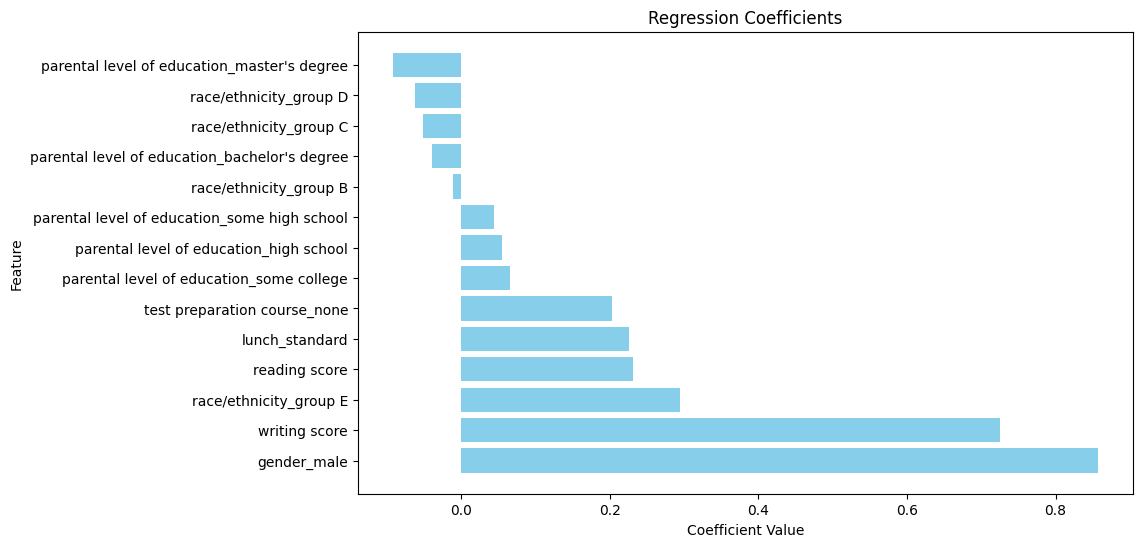

In [33]:
# Visualizing regression coefficients
plt.figure(figsize=(10, 6))
coefficients.sort_values(by="Coefficient", ascending=False, inplace=True)
plt.barh(coefficients["Feature"], coefficients["Coefficient"], color="skyblue")
plt.title("Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

In [28]:
# Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
#vif_data["Feature"] = X.columns #Original line causing error
vif_data["Feature"] = X_numeric.columns #changed line
# Ensure X contains only numeric data before applying VIF
X_numeric = X.select_dtypes(include=np.number)  # Select only numeric columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                   for i in range(X_numeric.shape[1])]
print("VIF Scores:\n", vif_data)

VIF Scores:
          Feature        VIF
0  reading score  11.268556
1  writing score  11.268556


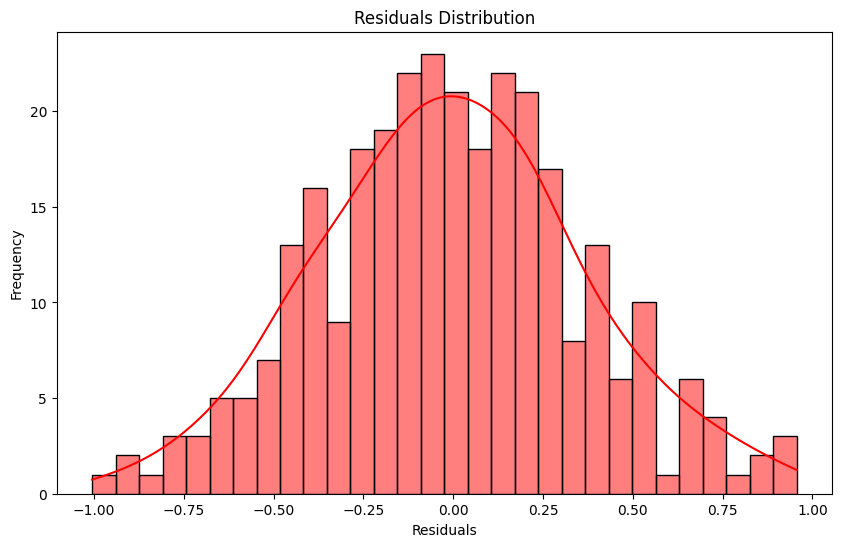

In [29]:
# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color="red")
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

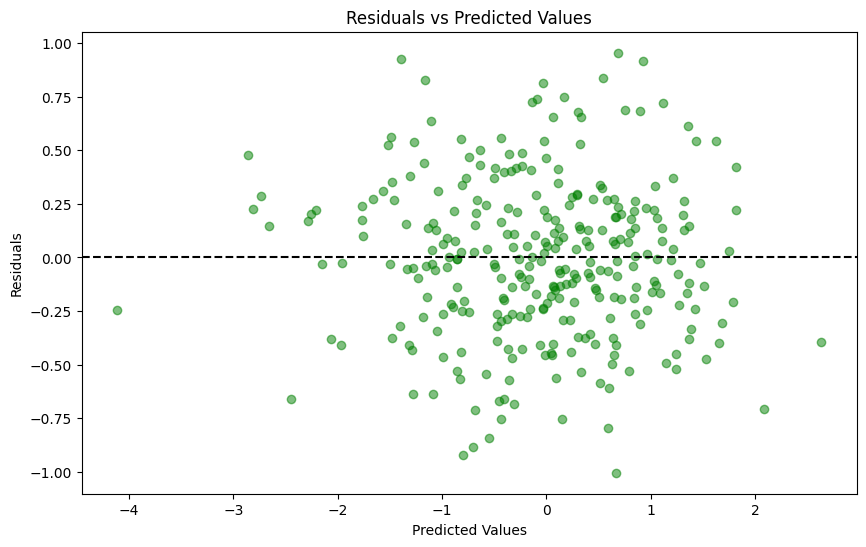

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color="green")
plt.axhline(0, linestyle="--", color="black")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

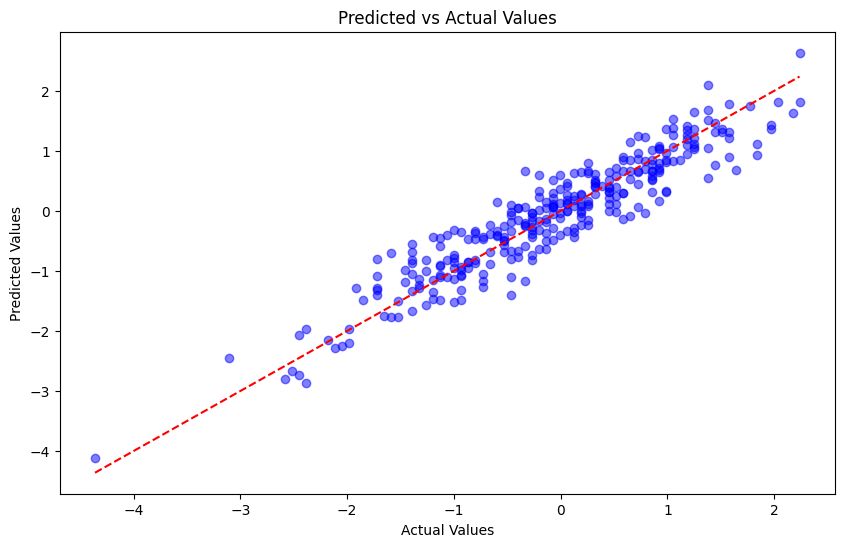

In [31]:
# Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.show()

# Conclusion

The regression analysis demonstrates a strong predictive power with an R² score of 0.88, indicating that 88% of the variance in students' math scores can be explained by the socioeconomic and demographic factors included in the model. The low mean squared error of 0.13 further validates the accuracy of the predictions. These findings highlight the significant influence of variables such as parental education, lunch type, and test preparation courses on academic performance. However, potential biases, such as unmeasured confounders and sample representativeness, warrant careful interpretation of results and consideration of these factors in policy design aimed at enhancing student outcomes.